<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Benjamin Constant
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** `http://....`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [2]:
df['Sex'].unique()

array([1., 0.])

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [3]:
!pip install xgboost

In [12]:
# Inserte su código aquí
from sklearn.model_selection import train_test_split
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder, RobustScaler,FunctionTransformer, OrdinalEncoder, QuantileTransformer
from sklearn.pipeline        import Pipeline, make_pipeline
from sklearn.metrics         import mean_absolute_error

import pickle
import xgboost
from xgboost import XGBRegressor
import datetime
import numpy as np

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import HistGradientBoostingRegressor

features = df.drop(columns='Diabetes')
labels   = df.loc[:,'Diabetes']

numeric_features = features.select_dtypes(include=np.number).columns

preproceso = ColumnTransformer([('Scaler', RobustScaler(),numeric_features)],
                              sparse_threshold=1,    verbose_feature_names_out=False
                                ).set_output(transform="pandas")
XGB_model = Pipeline([
    ('preprocesamiento',preproceso),
    ('regresor',XGBRegressor(objective='reg:squarederror',random_state=42,enable_categorical=True))
])

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42, stratify=labels)

XGB_model.fit(X_train,y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('Scaler', RobustScaler(),
                                                  Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP'],
      dtype='object'))],
                                   verbose_feature_names_ou...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [4]:
y_predict = XGB_model.predict(X_test)
print('MAE xgb:',mean_absolute_error(y_predict,y_test))
#print(classification_report(y_predict,y_test))

MAE xgb: 0.33587417647426226


La prediccion fue estable en base al MAE obtenido, por lo que el modelo funciona de manera correcta para predecir a las personas que tienen diabetes.
Los features utilizados fueron Age (Edad de la persona), Sex (Masculino o femenino, aun que no queda claro cual es cual ya que esta entre 0 y 1), HighChol (Si presenta colesteron alto), BMI (Es el indice de masa corporal), Smoker (Si fuma), HeartDiseaseorAttack (Si ha sufrido infarto agudo al miocardio), PhysActivity ( Si realiza actividad fisica), Fruits (Si consume frutas), Veggies (si tiene una alimentacion en base a vegetales), HvyAlcoholConsump (Si consume altas dosis de alcohol), GenHlth, MentHlth, PhysHelth, DiffWalk (Dificultad para caminar), Stroke, HighBP (hipertension arterial) y Diabetes. 

Los features como GenHlth, MenHlth y PhysHelth no encuentro una definicion correcta pero imagino que debe ser salud genetica, salud mental y salud fisica, respectivamente.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

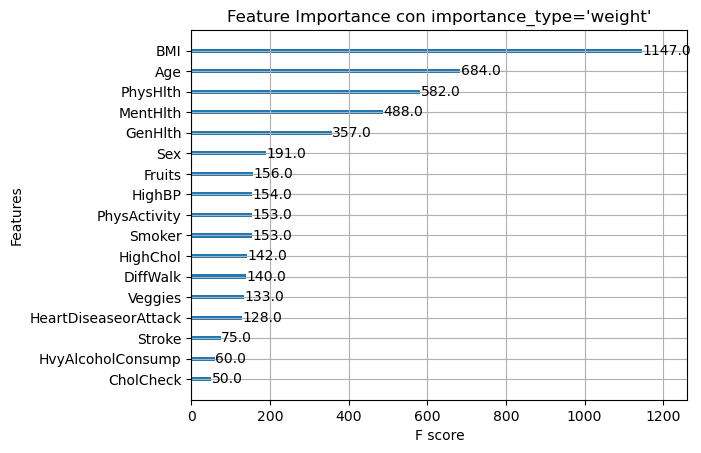

In [5]:
# Inserte su código aquí
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
xgb.plot_importance(clf, max_num_features=20)
plt.title("Feature Importance con importance_type='weight'")
plt.show()

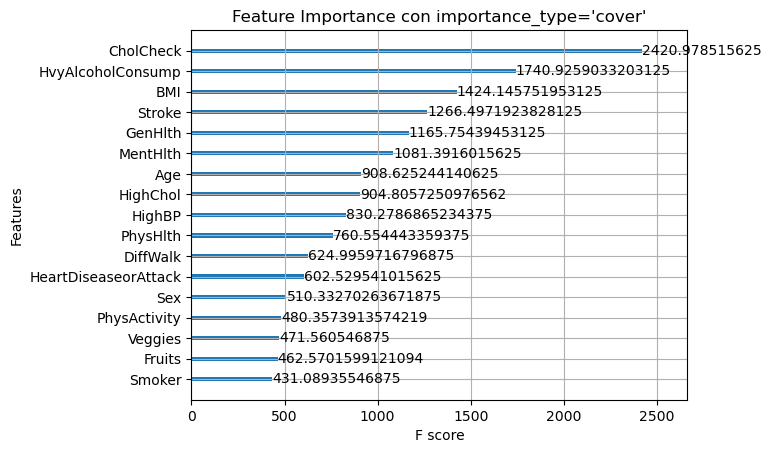

In [6]:
xgb.plot_importance(clf, max_num_features=20, importance_type="cover")
plt.title("Feature Importance con importance_type='cover'")
plt.show()

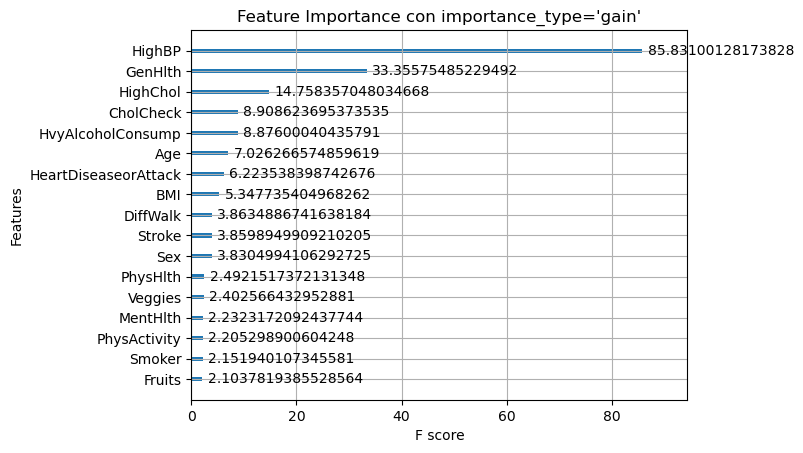

In [7]:
xgb.plot_importance(clf, max_num_features=20, importance_type="gain")
plt.title("Feature Importance con importance_type='gain'")
plt.show()

Para hacer un pequeño resumen, estos son los 3 features que mas le importa a cada modelo:
Weight
1) BMI, F score: 1147
2) Age, F score: 684
3) PhysHlth, F score: 582

Cover
1) CholCheck, F score: 2420.98
2) HvyAlcoholConsump, F score: 1740.93
3) BMI, F score: 1324

Gain
1) HighBP, F score: 85.83
2) GenHlth, F score: 33.35
3) HighChol, F score: 14.75

Cada modelo tiene una funcion en especifico, Weight analiza la cantidad de veces que se usa un feature para clasificar en el arbol, Cover la cantidad de datos afectadas por el feature especifico y gain mejora el proceso de clasificacion dandole importancia a un feature en funcion del rendimiento del modelo. Es por esto que si se analiza a simple vista los datos, la respuesta seria que no son compatibles, pero si nos vamos por lo que hace cada modelo, si son complementarios entre si.
Una cosa relevante en terminos de la diabete es la alimentacion, actividad fisica, consumo de carbohidratos (el alcohol posee un alto contenido de azucares o carbohidratos, por eso la cerveza engorda) y tendencia a la diabete (genetica), estos factores son los mas importantes, y gran parte de ellas se ve reflejada en los modelos. Sin embargo, la alimentacion pareciera que no se le toma mucha importancia sino mas que sus consecuencia en otras variables, por ejemplo una persona con "mala alimentacion" podria reflejar un BMI mas alto, pero este indice no es el mas representativo como lo podria ser el indice de glicemia que es la concentracion de glucosa libre en la sangre, que su alto indice podria indicar problemas con la regulacion del azucar y por ende podria ser indice de pre diabetes. 

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [8]:
# Inserte su código aquí
result = permutation_importance(XGB_model, X_test, y_test, n_repeats=30, random_state=42)
result

{'importances_mean': array([0.07031947, 0.00548526, 0.02507706, 0.00860226, 0.07827775,
        0.00202078, 0.01222421, 0.00163331, 0.00110994, 0.00204285,
        0.00905246, 0.12905189, 0.00295419, 0.00931053, 0.00865   ,
        0.00370456, 0.03978357]),
 'importances_std': array([0.00204101, 0.00081855, 0.0012898 , 0.00115775, 0.00243407,
        0.0004006 , 0.00110151, 0.00038893, 0.00062897, 0.00056308,
        0.0010247 , 0.00263779, 0.00105158, 0.00113773, 0.00093363,
        0.00075523, 0.0016689 ]),
 'importances': array([[ 7.02920038e-02,  6.57408813e-02,  7.17547376e-02,
          6.90082900e-02,  6.95959678e-02,  7.27908792e-02,
          7.20157590e-02,  7.09736969e-02,  6.91412474e-02,
          6.84969227e-02,  6.74368558e-02,  7.01373533e-02,
          7.21419785e-02,  7.23830135e-02,  7.10535976e-02,
          6.92183659e-02,  6.76083800e-02,  7.41269568e-02,
          6.69208863e-02,  6.81379353e-02,  7.03985740e-02,
          7.03009379e-02,  6.77988059e-02,  6.9915

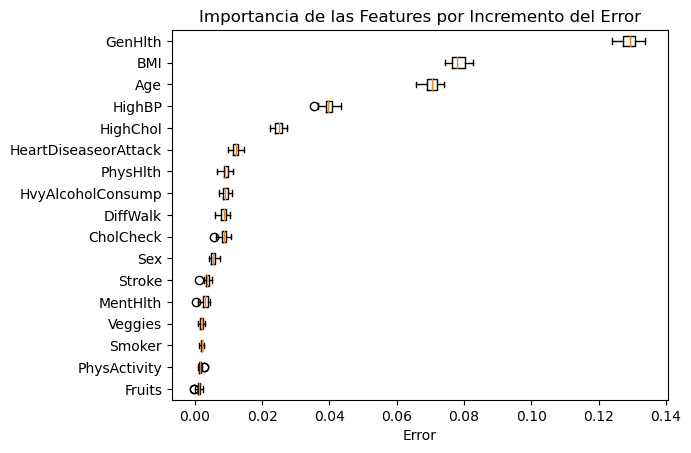

In [9]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(features.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

El modelo lo que realiza es cuando afecta al modelo si dicha variable no se encuentra para el entrenamiento del modelo o prediccion, obteniendo un grafico de importancia por cada feature. Si nos damos cuenta el error maximo es 14%, lo cual podria ser un factor no muy alto, lo que nos indica que no existe un feature tan impactante en el modelo como esperabamos.
El feature que tiene mayor importancia en este modelo es la genetica, lo cual si esta de acuerdo con los resultados anteriores, debido a que si uno tiene padres y/o abuelos con diabetes, la probabilidad de tener diabetes es mas alta, por lo que uno debiera tener mas cuidado con su alimentacion y su actividad fisica. Ademas, los primeros 5 features si fueron tomados en consideracion, al menos la gran parte, en los modelos anteriores y son los siguientes:

1) GenHlth : Me imagino que es la predisposicion de tener diabetes.
2) BMI: Indice de masa corporal. Esta variable no siento que sea tan importante por que una variable que mas peso tendria en el modelo, si estuviera, seria el indice de glicemia.
3) Age: Edad, a medida que uno es mas grande, es mas sedentario, por lo que la actividad fisica disminuye, lo que se traduce como una probabilidad de padecer diabetes. Sin embargo, esta variable debe ir de la mano de la genetica.
4) HighBP: presion arterial. Este es un buen feature para poder predecir la diabetes, debido que se usa como analisis en las clinicas para saber si uno tiene pre-disposicion a la diabete o bien a tenerla.
5) HighCol: Mide la cantidad de colesterol en la sangre. Esta variable se podria traducir como al aumentar la cantidad de azucar en el cuerpo, se almacena como grasa y por ende el mal procesamiento de esta podria generar diabetes.

El consumo de alcohol, el feature HvyAlcoholConsump, aparece en menor importancia que en los modelos anteriores, siendo esto quizas no muy efectivo. El consumo de alcohol genera un aumento en la glicemia del cuerpo y un exceso de trabajo tanto del higado, riñones y pancreas, por lo que su impacto si es directo en tener una predisposicion a tener diabetes, por lo cual el modelo debe definir su efecto en la variable HigCol como efecto de la alimentacion y por ende le dio mas importancia ya que en globaria mas variable de alimentacion en ella y eso explicaria el bajo efecto de las frutas en el modelo.

Por otro lado, el feature de actividad fisica es una variable muy importante para no padecer diabetes y aca no se le da tanta importancia en los modelos, pero esto se puede deber a que, nuevamente, se podria traducir en un impacto en los features de colesterol y PhysHlth, por lo que le da mas importancia a dichas variables que podrian englobar a otras variables.

las ventajas de usar este modelo son las siguientes:
1) Permite determinar el efecto de la ausencia de un feature en la prediccion del modelo. Esto me permite saber a que datos le debo tomar mas importancia y darles un "procesamiento" mas complejo a dichas variables para que se vean reflejados en el modelo.
2) Permite determinar la importancia de cada variable en el modelo, en base al error obtenido en el modelo.
3) Calcula la desviacion estandar de cada una de las variables, permitiendo obtener un rango de error y analizar de forma estadistica los efectos de cada variable en el modelo.

Las desventajas del modelo son las siguientes:
1) Tiempo y costo computacional, al tener que calcular la simulacion con la ausencia de cada features, hace que el modelo sea costoso y lento.
2) Problemas con el tamaño de los datos, igual que el punto anterior, si los datos utilizados para medir el efecto de cada feature son muy grandes, el modelo seria aun mas lento y costoso a nivel computacional.
3) No realiza correlaciones no lineales, pudiendo no entender el multiefecto de diferentes variables, como la PhysHlth con la actividad fisica y el consumo de alcohol.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [11]:
!pip install shap

In [13]:
import warnings
import shap
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [14]:
# Inserte código para calcular shapley values aquí
features = df.drop(columns='Diabetes')
labels   = df.loc[:,'Diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42, stratify=labels)

model_shap = xgb.XGBClassifier()
model_shap.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
predict = model_shap.predict(X_test)
print(classification_report(predict,y_test))

              precision    recall  f1-score   support

           0       0.70      0.77      0.74     10671
           1       0.79      0.73      0.76     12658

    accuracy                           0.75     23329
   macro avg       0.75      0.75      0.75     23329
weighted avg       0.75      0.75      0.75     23329



In [16]:
Xd = xgboost.DMatrix(features,label=labels)

In [26]:
explicacion = shap.TreeExplainer(model_shap)
shap_values =explicacion(X_test)

[15:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [27]:
shap_values

.values =
array([[-0.15623099, -0.09250835, -0.27305958, ..., -0.03750481,
        -0.02435738, -0.6868826 ],
       [ 0.23196153,  0.16088767,  0.15957026, ...,  0.30385444,
        -0.02739327,  0.37392056],
       [-0.4571834 ,  0.1571701 ,  0.39694482, ...,  0.02246409,
         0.00473362, -0.44911283],
       ...,
       [-0.07911266, -0.09084407,  0.25722373, ..., -0.07804816,
        -0.0272058 ,  0.39193004],
       [ 0.3083511 ,  0.0565517 ,  0.16133577, ..., -0.04712358,
        -0.01172105,  0.31975725],
       [-0.47235003, -0.04820711, -0.48638886, ...,  0.1276718 ,
        -0.01698893,  0.5150786 ]], dtype=float32)

.base_values =
array([-0.00817224, -0.00817224, -0.00817224, ..., -0.00817224,
       -0.00817224, -0.00817224], dtype=float32)

.data =
array([[ 8.,  0.,  0., ...,  0.,  0.,  0.],
       [13.,  1.,  1., ...,  1.,  0.,  1.],
       [ 6.,  1.,  1., ...,  1.,  0.,  0.],
       ...,
       [ 8.,  0.,  1., ...,  0.,  0.,  1.],
       [11.,  1.,  1., ...,  0.,  0.

In [28]:
shap_values.values[1,:]

array([ 2.3196153e-01,  1.6088767e-01,  1.5957026e-01,  1.4263329e-02,
       -1.9093880e-01, -2.7170086e-02,  2.4036440e-01,  2.6114298e-02,
        1.4879082e-04, -1.6755614e-02,  3.0811407e-02,  1.4935625e-01,
       -3.1985994e-02,  3.9490440e-04,  3.0385444e-01, -2.7393268e-02,
        3.7392056e-01], dtype=float32)

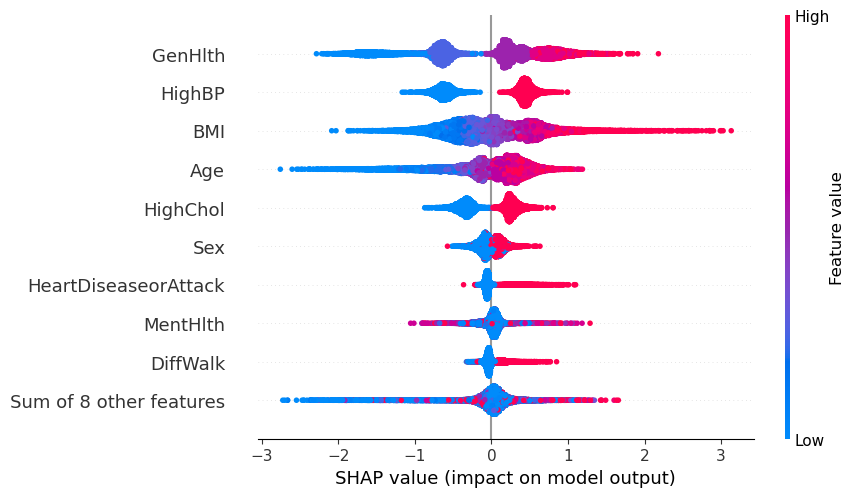

In [29]:
shap.plots.beeswarm(shap_values)

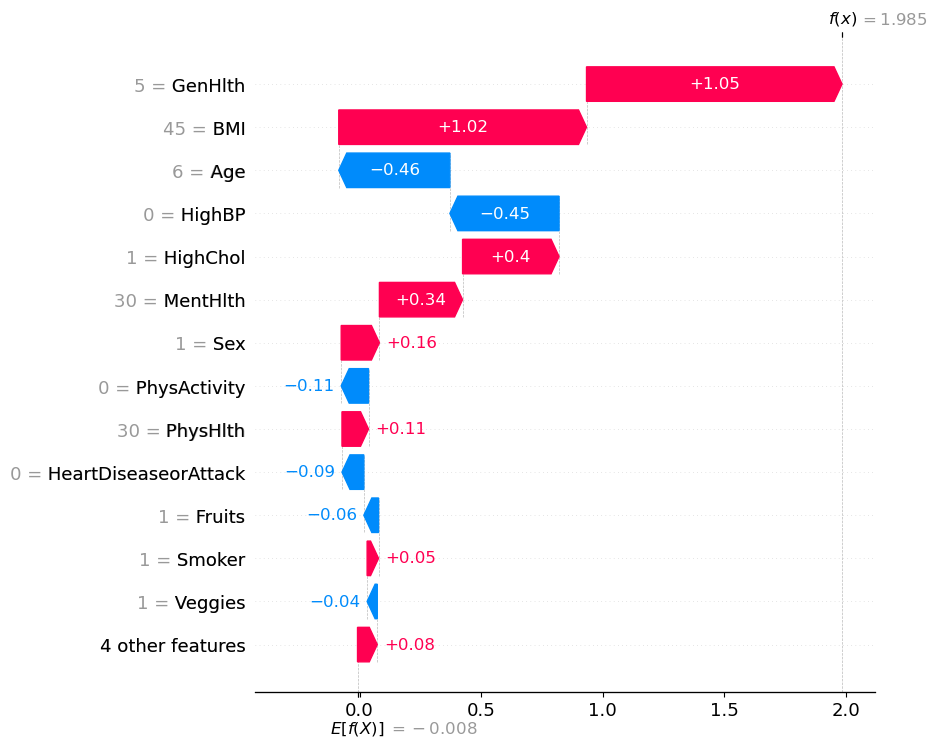

In [30]:
idx=2
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

La libreria SHAP intenta darle un sentido logico a lo que ocurre dentro de un modelo de IA, por lo que usa un sistema basado en la teoria de juego para poder atribuir importancia a las variables que se estan usando para entrenar el modelo.
Para poder obtener los valores de SHAP, primero se debe entrenar un modelo de clasificacion y luego graficar los datos para ver los efectos y su relevancia en el modelo. En genera los valores que se ven en rojo de cada feature tiene un efecto positivo en el modelo, mejora su aprendizaje, mientras que un valor azul y negativo nos dicen que tiene un efecto negativo en el modelo.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [31]:
# Inserte código para generar gráficos de aporte local aquí
idx = 1

shap.initjs()
shap.force_plot(explicacion.expected_value, 
                shap_values.values[idx,:], 
                X_test.iloc[idx,:],
                link="logit")

In [32]:
idx = 9

shap.initjs()
shap.force_plot(explicacion.expected_value, 
                shap_values.values[idx,:], 
                X_test.iloc[idx,:],
                link="logit")

In [33]:
idx = 150

shap.initjs()
shap.force_plot(explicacion.expected_value, 
                shap_values.values[idx,:], 
                X_test.iloc[idx,:],
                link="logit")

Por lo que podemos notar, en funcion de cada individuo que se usa para representar como sus features ayudan o dificultan la clasificacion, varia segun sus datos ya que notamos que el BMI en la ultima persona tiene un efecto positivo en la prediccion pero en los anteriores no, por lo que no se puede generalizar el aporte de cada feature en base a observaciones individuales

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

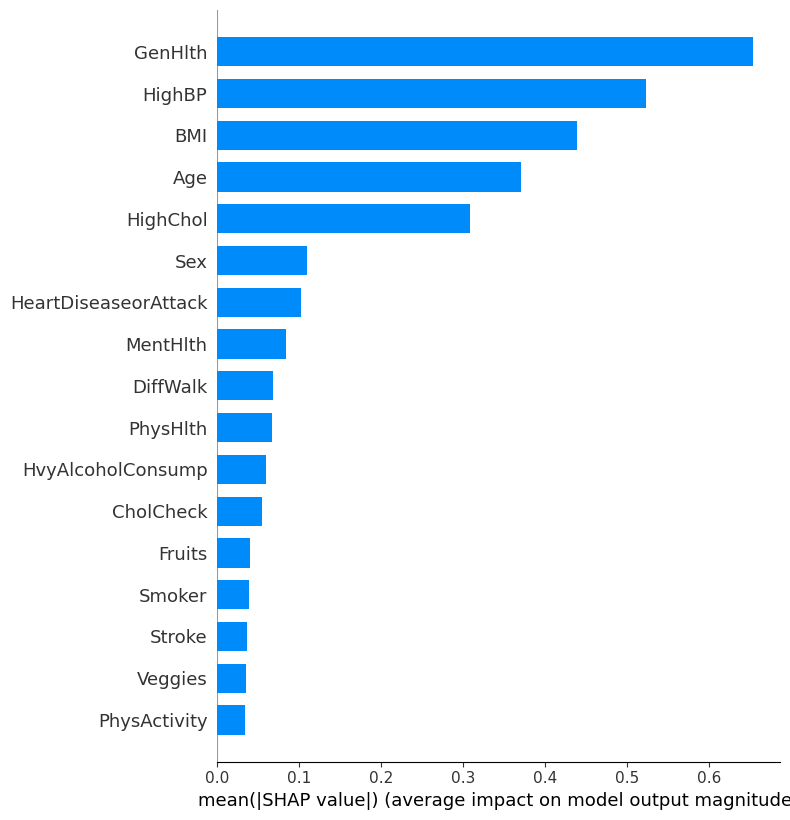

In [34]:
# Inserte código para generar gráficos de aporte global aquí
shap.summary_plot(shap_values,X_test,plot_type='bar')

El cambio mas notorio entre el balance Global vs el individual, es el feature BMI en donde en los dos primeros casos este feature tiene un efecto negativo en la prediccion del modelo, mientras que a nivel Global es uno de los features mas importantes para poder predecir si la persona tiene diabetes o no.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [36]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]
feature_importance_names

Index(['GenHlth', 'HighBP', 'BMI', 'Age', 'HighChol', 'Sex',
       'HeartDiseaseorAttack', 'MentHlth', 'DiffWalk', 'PhysHlth',
       'HvyAlcoholConsump', 'CholCheck', 'Fruits', 'Smoker', 'Stroke',
       'Veggies', 'PhysActivity'],
      dtype='object')

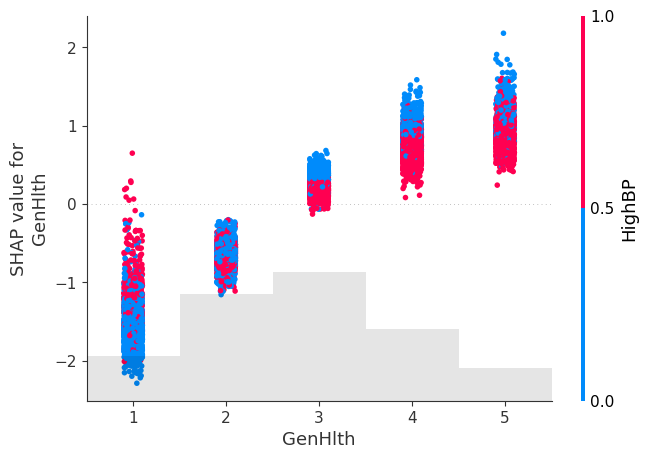

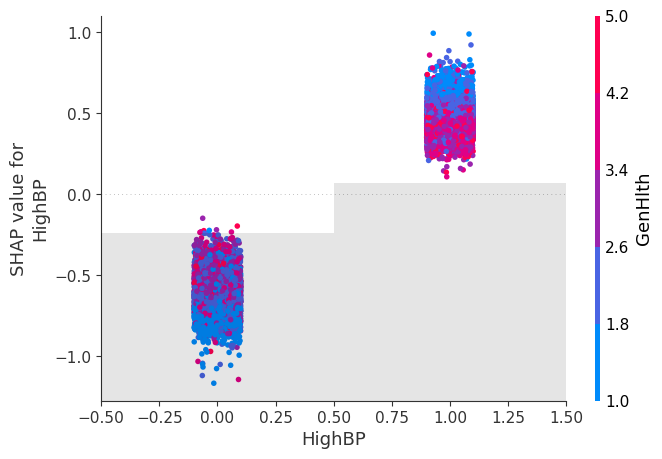

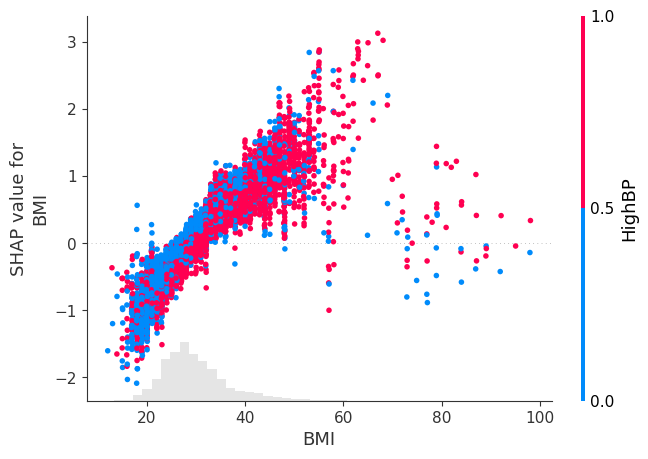

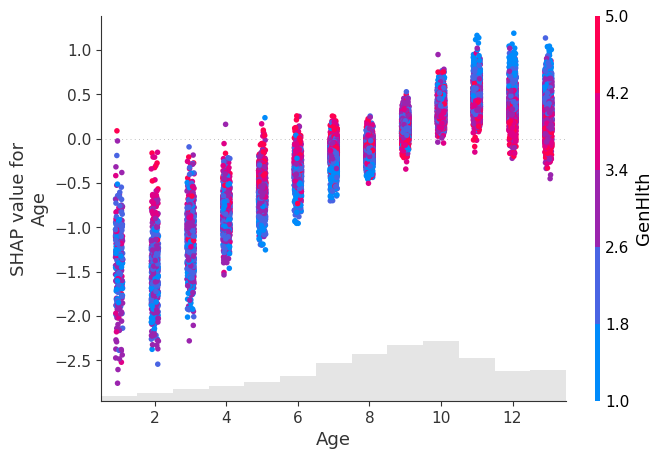

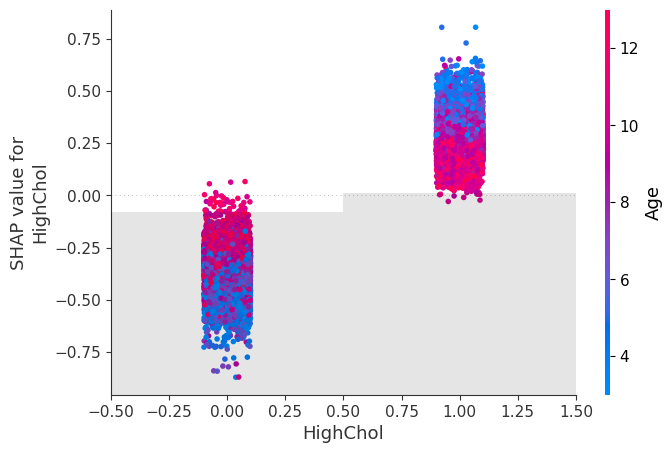

In [37]:
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

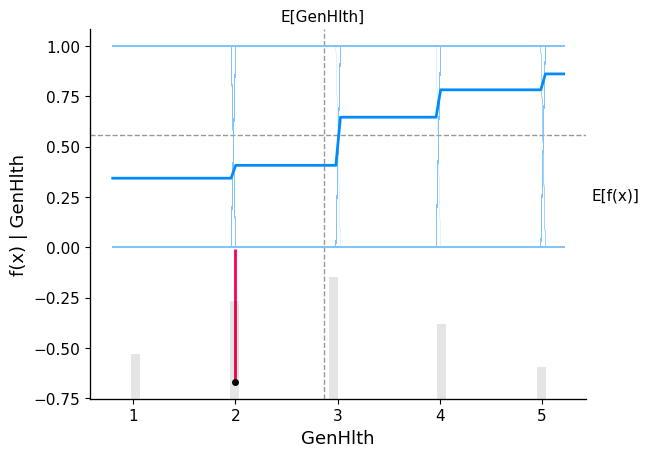

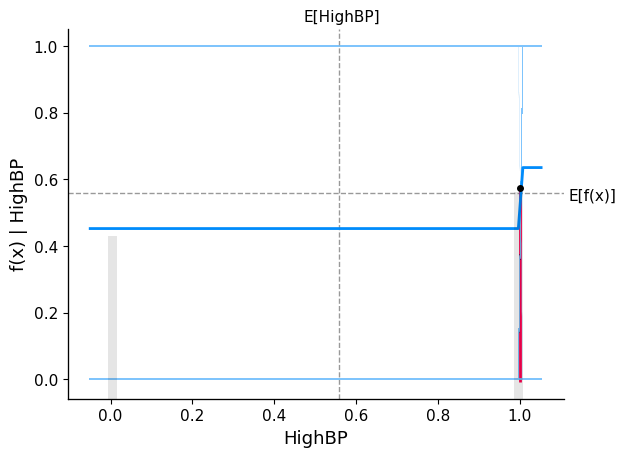

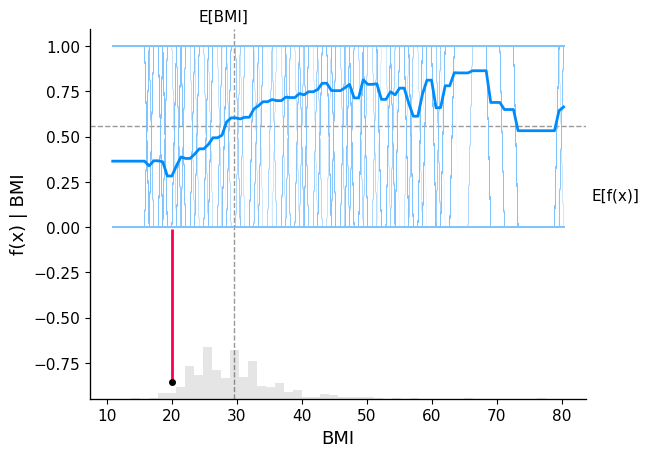

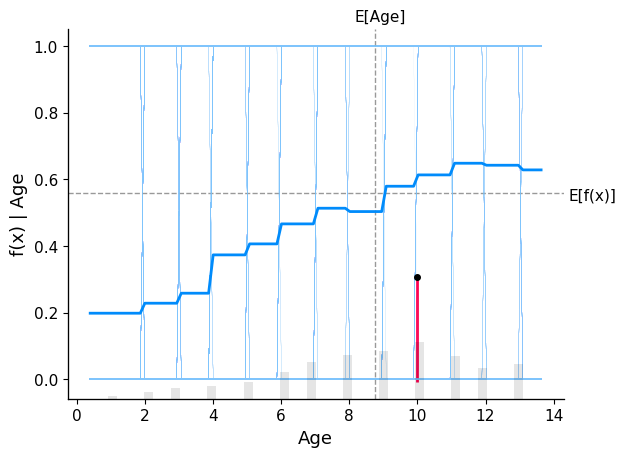

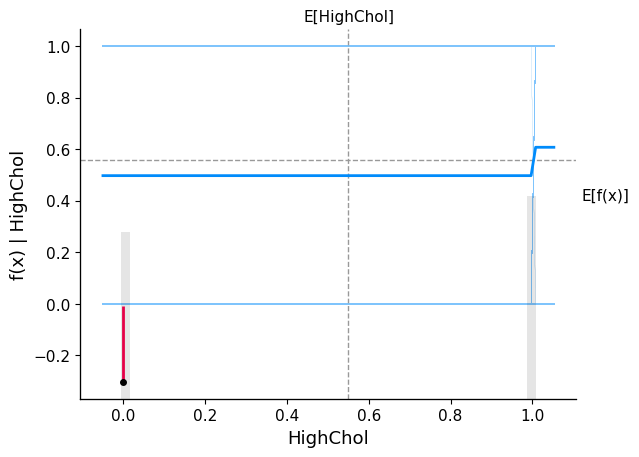

In [42]:
X1000 = shap.utils.sample(features, 1000)

sample_ind = 20
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
    name, model_shap.predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [18]:
#!pip install alibi
#!pip install alibi[ray]

In [44]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: model_shap.predict(x)
explainer = AnchorTabular(predict_fn, model_shap.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [47]:
explainer.predictor(X_test.to_numpy()[1000].reshape(1, -1))[0]

0

In [48]:
class_names = ["no diabetes", "diabetes"]
idx = 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

idx = 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

idx = 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  no diabetes
Anchor: HvyAlcoholConsump > 0.00 AND BMI <= 25.00 AND GenHlth <= 2.00
Precision: 0.99
Coverage: 0.01
Prediction:  no diabetes
Anchor: GenHlth <= 2.00 AND HighBP <= 0.00 AND Age <= 7.00
Precision: 0.98
Coverage: 0.13


Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Prediction:  diabetes
Anchor: BMI > 29.00 AND HighBP > 0.00 AND Age > 7.00 AND HvyAlcoholConsump <= 0.00 AND Veggies <= 1.00
Precision: 0.95
Coverage: 0.23


Como hemos comentado a lo largo de todo el laboratorio, notamos que se siguen repitiendo las variables BMI y GenHlth como los primeros filtros, por lo que sigue estando una tendencia clara en los diferentes modelos usados. Lo que si es interesante y que demuestra algo contrario a las importancias de los demas features y es que sale como features importantes de clasificacion los features Age y veggies, las cuales no tendrian un peso tan relevante en los modelos de clasificacion anteriormente mostrado. Sin embargo, cuando analizamos las predicciones de persona a persona en SHAP, pudimos notar que los efectos de cada feature era distintos para cada persona, por lo que es correcto los resultados mostrados por el modelo alibi.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

El metodo que mayor conclusiones es el de SHAP debido a que es un sistema mas robusto que le da un significado a cada una de las "Funciones" del modelo, permitiendo interpretar de forma clara los datos. El metodo mas util es shap global debido a que le entrega la relevancia de cada features y asi puede enfocarse en que datos se debe preocupar mas para poder mejorar el modelo.
No es conveniento usar un metodo de agnostico local debido a que cada "persona" les afectan algunas variables de forma distintas como fue el caso de BMI, en donde de forma global notamos la importancia de este pero de forma local no funcionaba de forma positiva para predecir si la persona podria tener diabetes o no. Sin embargo, si se desea hacer un estudio mas especifico con una persona y no solo tomar los datos de manera rapida, podria ser recomendable los analisis locales para poder atender de mejor manera al cliente que desea ser apoyado en temas de diabetes ( de si tiene o no y como prevenirlo).

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>